# Introduction to statsmodels

* [`statsmodels`](http://www.statsmodels.org/stable/index.html) is a Python package that allows you to estimate common econometric models
* Still in development and not as full-featured as econometrics in R or STATA
* Can use in conjuction with pandas

### Reading

https://lectures.quantecon.org/py/ols.html

Start by importing dataframes from our earlier tutorial

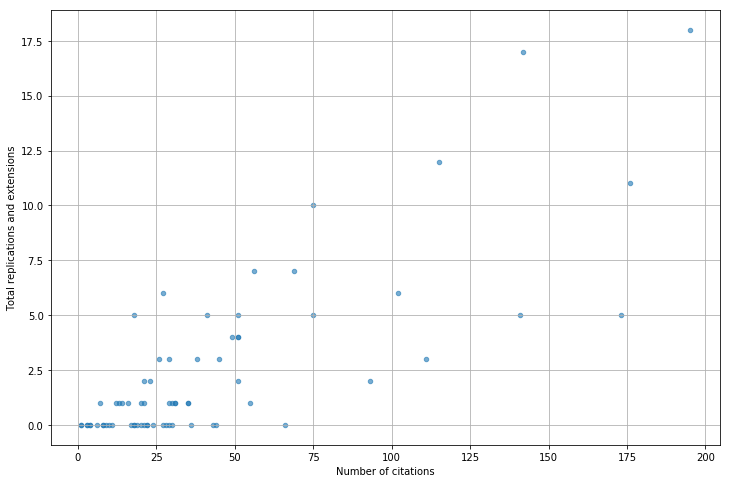

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

merged = pd.read_csv('merged.csv')
merged.plot(x='volWoS', y='total', kind='scatter', alpha=0.6, figsize=(12, 8))
plt.ylabel('Total replications and extensions')
plt.xlabel('Number of citations')

plt.grid()
plt.show()

From the plot, it appears that citations are positively correlated with total number of replications and extensions

We may want to know more about this relationship:
* do citation counts affect total replications/extensions?
* is this relationship statistically significant?
* are there statistically significant differences across fields?

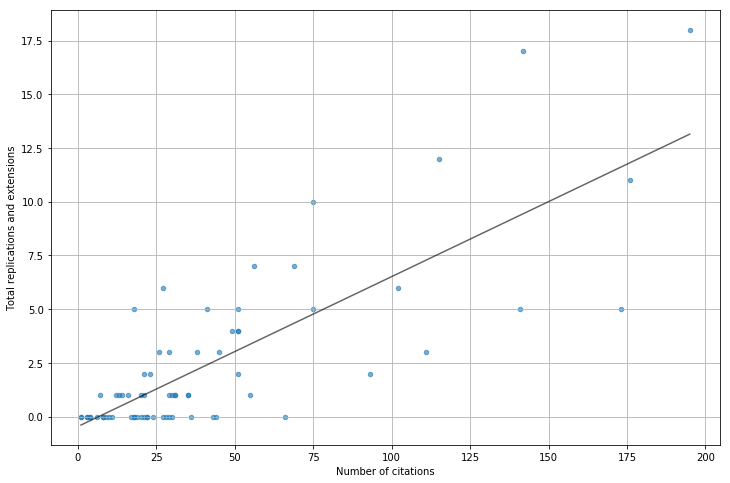

In [49]:
merged = pd.read_csv('merged.csv')
merged.plot(x='volWoS', y='total', kind='scatter', alpha=0.6, figsize=(12, 8))
plt.ylabel('Total replications and extensions')
plt.xlabel('Number of citations')

plt.plot(np.unique(merged['volWoS']),
         np.poly1d(np.polyfit(merged['volWoS'], merged['total'], 1))(np.unique(merged['volWoS'])),
         color='black', alpha=0.6)

plt.grid()
plt.show()

To attempt to answer these questions, we can fit a linear line - in other words use a **linear regression model**

$$
y_t = \beta_0 + \beta_1 x + u_t \\
total_t = \beta_0 + \beta_1 citations_t + u_t
$$

* $\beta_0$ is the constant term
* $\beta_1$ is the slope term
* $u_t$ is the error term

To estimate $\beta_0$, we will need to add a column of 1's to our dataframe

In [50]:
merged['constant'] = 1

### Using statsmodels

We will use statsmodels' OLS (ordinary least squares) function to estimate our linear regression model

In [51]:
import statsmodels.api as sm

reg = sm.OLS(endog=merged['total'], exog=merged[['constant', 'volWoS']], missing='drop')

We then use `.fit()` to estimate the parameters

In [74]:
results = reg.fit()
results

In [75]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  total   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     114.5
Date:                Sun, 28 Jan 2018   Prob (F-statistic):           3.21e-16
Time:                        04:21:33   Log-Likelihood:                -157.62
No. Observations:                  70   AIC:                             319.2
Df Residuals:                      68   BIC:                             323.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant      -0.4642      0.391     -1.187      0.2

The results show...
* Citations are positively related to replications/extensions, as expected
* This relationship is statistically significant (p < 0.05)
* A moderate amount of variance in replications/extensions can be explained by variance in citations ($R^2$ = 0.63)

We can retrieve our predicted results with `.predict()`

In [54]:
results.predict()

array([  0.44287925,   1.00110412,  -0.18512374,   2.04777576,
         1.559329  ,   9.44425536,   2.60600064,   1.21043845,
         0.72199169,  -0.25490184,   1.41977278,   3.09444741,
        -0.25490184,   0.37310114,   0.7917698 ,   4.35045337,
         0.30332303,   3.37355984,   0.65221358,   1.559329  ,
         0.16376681,   1.34999467,   2.67577875,   1.69888522,
         1.07088223,   6.65313098,   2.18733198,   3.09444741,
         3.09444741,   0.23354492,   1.00110412,   0.02421059,
         0.0939887 ,   0.7917698 ,  11.81671108,   0.86154791,
         4.76912203,   1.14066034,   0.93132601,   1.00110412,
         7.28113397,   0.0939887 ,   4.14111905,   1.48955089,
         3.44333795,  -0.39445806,   1.97799766,   1.41977278,
         3.09444741,   7.56024641,   2.39666631,   2.95489119,
         4.76912203,   0.51265736,  13.14249515,  -0.18512374,
         6.025128  ,  -0.39445806,   0.93132601,   1.07088223,
         0.7917698 ,   1.62910711,   1.62910711,  11.60

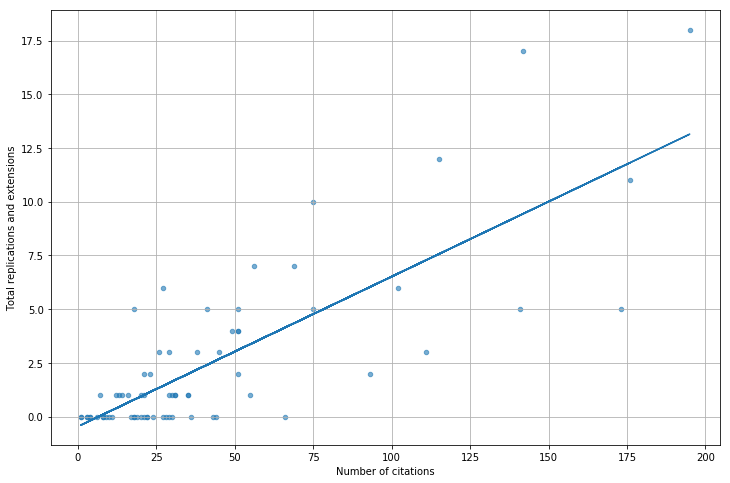

In [55]:
merged.plot(x='volWoS', y='total', kind='scatter', alpha=0.6, figsize=(12, 8))
plt.ylabel('Total replications and extensions')
plt.xlabel('Number of citations')

plt.plot(merged['volWoS'], results.predict())

plt.grid()
plt.show()

### Using robust standard errors

It is useful to check your residual plot after estimating your model

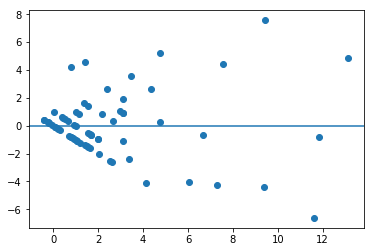

In [91]:
plt.scatter(results.predict(), results.resid)
plt.axhline()
plt.show()

The above plot shows that errors are generally well distributed about 0, however variance increases with the dependent variable

This is known as **heteroskedascity**

When heteroskedascity is present, robust standard errors should be used

In [81]:
results = reg.fit(cov_type='HC0')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  total   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     33.53
Date:                Sun, 28 Jan 2018   Prob (F-statistic):           1.97e-07
Time:                        04:24:54   Log-Likelihood:                -157.62
No. Observations:                  70   AIC:                             319.2
Df Residuals:                      68   BIC:                             323.7
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
constant      -0.4642      0.367     -1.266      0.2

### Adding dummies

We can expand our model to include more variables that we believe may affect total replications and extensions

To add a paper's field, we need to create **dummy variables**

$$
total_t = \beta_0 + \beta_1 citations_t + \beta_2 behavioural + \beta_3 development + \beta_4 labor + \beta_5 macro +  u_t
$$

To avoid multicollinearity, we need to drop one of our fields
* this implies that the 'base case' is a general applied paper

In [56]:
dummies = pd.get_dummies(merged['volField'], drop_first=True)
dummies.head()

,Behavioral/Exp.,Development,Labor/IO,Macro/Int/Trade
0,0,0,0,0
1,0,0,1,0
2,0,0,0,0
3,0,0,0,1
4,0,0,1,0


In [57]:
merged = pd.merge(merged, dummies, left_index=True, right_index=True)
merged.head()

,Unnamed: 0,index,volTitle,volID,volCoder,volWoS,volTop200Econ,volGScites,volField,totalCites,replication,extension,total,constant,Behavioral/Exp.,Development,Labor/IO,Macro/Int/Trade
0,0,0,A New Approach to Estimating the Production Fu...,37,5.0,13,11.0,74,Applied (gen.),98.0,0.0,1.0,1.0,1,0,0,0,0
1,1,1,A Study of the Internal Organization of a Bidd...,32,5.0,21,11.0,127,Labor/IO,159.0,0.0,0.0,0.0,1,0,0,1,0
2,2,2,A Theory of Optimal Random Crackdowns,44,5.0,4,2.0,41,Applied (gen.),47.0,0.0,0.0,0.0,1,0,0,0,0
3,3,3,An Exploration of Technology Diffusion,84,2.0,36,16.0,226,Macro/Int/Trade,278.0,0.0,0.0,0.0,1,0,0,0,1
4,4,4,Are Health Insurance Markets Competitive?,58,5.0,29,16.0,139,Labor/IO,184.0,0.0,0.0,0.0,1,0,0,1,0


In [84]:
reg_2 = sm.OLS(endog=merged['total'], 
               exog=merged[['constant', 'volWoS', ] + list(dummies.columns)], 
               missing='drop')

In [87]:
results_2 = reg_2.fit(cov_type='HC0')
print(results_2.summary())

                            OLS Regression Results                            
Dep. Variable:                  total   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     22.92
Date:                Sun, 28 Jan 2018   Prob (F-statistic):           4.14e-13
Time:                        04:25:44   Log-Likelihood:                -143.39
No. Observations:                  70   AIC:                             298.8
Df Residuals:                      64   BIC:                             312.3
Df Model:                           5                                         
Covariance Type:                  HC0                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
constant           -0.8136      0.742     

The results show that...
* Behavioural papers are statistically significantly different from the base case
* Behavioural papers have 2.6 more replications or extensions compared to general applied papers
* The adjusted $R^2$ has increased to 0.73 -> papers' fields were able to explain more variation in total replications and extensions